In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.interpolate import RegularGridInterpolator
import mrcfile
# import utils
import sys, os
parent_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), ''))
sys.path.insert(0,parent_dir)
from utils import *

ticksize = 12
labelsize = 14
titlesize = 16
linewidth = 2
dpi = 400
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

In [5]:
# read in all Q-score information
col_names = ['atom_name','residue_number','residue_name','x_coord','y_coord','z_coord','Qscore']
df22in23 = pd.read_csv('../../models/Qscore/outputs/22in23.pdb__Q__Con1_2.3A_sh.mrc.csv',names=col_names)
df22in23['residue_number'] = df22in23.residue_number.str[:-2].astype(int)
df23in22 = pd.read_csv('../../models/Qscore/outputs/23in22.pdb__Q__Con2-2.2A_sh.mrc.csv',names=col_names)
df23in22['residue_number'] = df23in22.residue_number.str[:-2].astype(int)

col_names = ['atom_name','residue_number','residue_name','x_coord','y_coord','z_coord','Qscore_A']
df22in23halfA = pd.read_csv('../../models/Qscore/outputs/22in23.pdb__Q__Con1_2.3A_sh_half_A.mrc.csv',names=col_names)
df22in23halfA['residue_number'] = df22in23halfA.residue_number.str[:-2].astype(int)
df23in22halfA = pd.read_csv('../../models/Qscore/outputs/23in22.pdb__Q__Con2-2.2A_sh_half_A.mrc.csv',names=col_names)
df23in22halfA['residue_number'] = df23in22halfA.residue_number.str[:-2].astype(int)
col_names = ['atom_name','residue_number','residue_name','x_coord','y_coord','z_coord','Qscore_B']
df22in23halfB = pd.read_csv('../../models/Qscore/outputs/22in23.pdb__Q__Con1_2.3A_sh_half_B.mrc.csv',names=col_names)
df22in23halfB['residue_number'] = df22in23halfB.residue_number.str[:-2].astype(int)
df23in22halfB = pd.read_csv('../../models/Qscore/outputs/23in22.pdb__Q__Con2-2.2A_sh_half_B.mrc.csv',names=col_names)
df23in22halfB['residue_number'] = df23in22halfB.residue_number.str[:-2].astype(int)

df = pd.read_csv('all_solvent_consensus_status_withconsensus.csv')
#df = pd.read_csv('../analysis/all_solvent_consensus_status.csv')
df22 = df[df.model == '2.2Å']
df23  = df[df.model == '2.3Å']
df22 = df22in23.merge(df22,left_on=['atom_name','residue_number'],right_on=['solvent','residue_number'],validate='1:1')
df23 = df23in22.merge(df23,left_on=['atom_name','residue_number'],right_on=['solvent','residue_number'],validate='1:1')
df22 = df22in23halfA.merge(df22,left_on=['atom_name','residue_number'],right_on=['solvent','residue_number'],validate='1:1')
df23 = df23in22halfA.merge(df23,left_on=['atom_name','residue_number'],right_on=['solvent','residue_number'],validate='1:1')
df22 = df22in23halfB.merge(df22,left_on=['atom_name','residue_number'],right_on=['solvent','residue_number'],validate='1:1')
df23 = df23in22halfB.merge(df23,left_on=['atom_name','residue_number'],right_on=['solvent','residue_number'],validate='1:1')

In [6]:
# calculate map values
get_mapvalue = get_density_interpolator(MRC23_F)
mapvalue22 = []
for k in tqdm(range(len(df22))):
    current_atom = df22.iloc[k]
    atom_coord = current_atom[['x_coord','y_coord','z_coord']].to_list()

    coord = np.array(atom_coord)
    mapvalue22.append(get_mapvalue(coord)[0])
    
get_mapvalue = get_density_interpolator(MRC22_F)
mapvalue23 = []
for k in tqdm(range(len(df23))):
    current_atom = df23.iloc[k]
    atom_coord = current_atom[['x_coord','y_coord','z_coord']].to_list()

    coord = np.array(atom_coord)
    mapvalue23.append(get_mapvalue(coord)[0])

100%|█████████████████████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 1271.56it/s]


In [7]:
df22['within 1A of wat in 8hd7']

0      0
1      0
2      0
3      0
4      0
      ..
316    0
317    0
318    0
319    0
320    0
Name: within 1A of wat in 8hd7, Length: 321, dtype: int64

In [15]:
df22['mapvalue']=mapvalue22
df23['mapvalue']=mapvalue23
mrc = mrcfile.open(MRC22_F)
mean22mrc = mrc.data.mean()
mean22std = mrc.data.std()
mrc = mrcfile.open(MRC23_F)
mean23mrc = mrc.data.mean()
mean23std = mrc.data.std()
print(mean22mrc,mean22std,mean23mrc,mean23std)
def get_overlap(row,tpye,struct):
    if tpye == 'wat':
        othertype = 'mg'
    elif tpye == 'mg':
        othertype = 'wat'
        
    #if row[f'within 1A of {tpye} in {struct}']>0 and row[f'exact binding spot of {tpye} in {struct}']>0:
    #    return "Overlap"
    if row[f'consensus of {tpye} in {struct}']:
        return "Overlap"
    #elif row[f'within 1A of {tpye} in {struct}']>0 or row[f'exact binding spot of {tpye} in {struct}']>0 or row[f'within 1A of {othertype} in {struct}']>0 or row[f'exact binding spot of {othertype} in {struct}']>0:
    elif row[f'within 1A of {tpye} in {struct}']!='0' or row[f'binding spot of {tpye} in {struct}']>0 or row[f'within 1A of {othertype} in {struct}']!='0' or row[f'binding spot of {othertype} in {struct}']>0:
        retstr = ''
        if row[f'within 1A of {tpye} in {struct}']!='0':
            retstr += f" within 1A {tpye}"
        #if row[f'exact binding spot of {tpye} in {struct}']>0:
        if row[f'binding spot of {tpye} in {struct}']>0:
            retstr += f" same binding site {tpye}"
        #if row[f'within 1A of {othertype} in {struct}']>0 and row[f'exact binding spot of {othertype} in {struct}']>0:
        if row[f'within 1A of {othertype} in {struct}']!='0' and row[f'binding spot of {othertype} in {struct}']>0:
            retstr += f' overlap {othertype}'
        elif row[f'within 1A of {othertype} in {struct}']!='0':
            retstr += f" within 1A {othertype}"
        #elif row[f'exact binding spot of {othertype} in {struct}']>0:
        elif row[f'binding spot of {othertype} in {struct}']>0:
            retstr += f" same binding site {othertype}"
        return retstr
    else:
        return "no overlap"

    
df22["overlap water"] = df22.apply(lambda row: get_overlap(row,'wat','2.3Å'), axis=1)
df22["overlap mg"] = df22.apply(lambda row: get_overlap(row,'mg','2.3Å'), axis=1)
df22wat = df22[df22.solvent == "HOH"]
df22mg = df22[df22.solvent == "MG"]
df23["overlap water"] = df23.apply(lambda row: get_overlap(row,'wat','2.2Å'), axis=1)
df23["overlap mg"] = df23.apply(lambda row: get_overlap(row,'mg','2.2Å'), axis=1)
df23wat = df23[df23.solvent == "HOH"]
df23mg = df23[df23.solvent == "MG"]

6.4574124e-09 0.9999984 -1.846638e-08 0.99999803


In [16]:
df22wat_non = df22wat[df22wat["overlap water"]=="no overlap"].copy()
df22mg_non = df22mg[df22mg["overlap mg"]=="no overlap"].copy()
df23wat_non = df23wat[df23wat["overlap water"]=="no overlap"].copy()
df23mg_non = df23mg[df23mg["overlap mg"]=="no overlap"].copy()

In [17]:
values22 = [(df22wat["overlap water"]=='Overlap').sum(),
            (df22wat["overlap water"].str.contains('same binding site wat')).sum(),
            (df22wat["overlap water"].str.contains('within 1A wat')).sum(),
            (df22wat["overlap water"]==' overlap mg').sum(),
            (df22wat["overlap water"]==' same binding site mg').sum(),
            (df22wat["overlap water"]==' within 1A mg').sum(),
            (df22wat["overlap water"]=='no overlap').sum()]
values23 = [(df23wat["overlap water"]=='Overlap').sum(),
            (df23wat["overlap water"].str.contains('same binding site wat')).sum(),
            (df23wat["overlap water"].str.contains('within 1A wat')).sum(),
            (df23wat["overlap water"]==' overlap mg').sum(),
            (df23wat["overlap water"]==' same binding site mg').sum(),
            (df23wat["overlap water"]==' within 1A mg').sum(),
            (df23wat["overlap water"]=='no overlap').sum()]

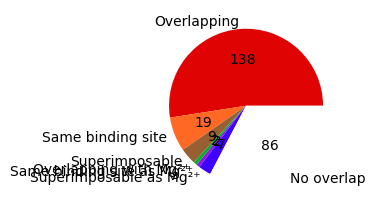

In [18]:
labels = ['Overlapping','Same binding site','Superimposable','Overlapping with Mg²⁺','Same binding site as Mg²⁺','Superimposable as Mg²⁺','No overlap']
colors = ['#df0303','#ff6924','#976032','#00af2b','#901cd8','#3e00fc','white']

plt.figure(figsize=(2.5,2.5))
_=plt.pie(values22,colors=colors,labels=labels,autopct=autopct_format(values22))
plt.savefig("Supplpie_wat_22.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_wat_22.svg", bbox_inches="tight")

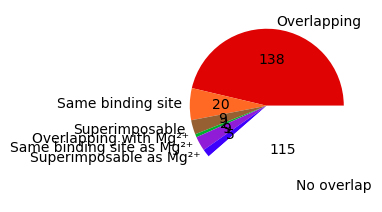

In [20]:
plt.figure(figsize=(2.5,2.5))
_=plt.pie(values23,colors=colors,labels=labels,autopct=autopct_format(values23))
plt.savefig("Supplpie_wat_23.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_wat_23.svg", bbox_inches="tight")

In [21]:
labels = ['Overlapping','Same binding site','Superimposable','Overlapping with H₂O','Same binding site as H₂O','Superimposable as H₂O','No overlap']
colors = ['#00af2b','#901cd8','#3e00fc','#df0303','#ff6924','#976032','white']

values22 = [(df22mg["overlap mg"]=='Overlap').sum(),
            (df22mg["overlap mg"].str.contains('same binding site mg')).sum(),
            (df22mg["overlap mg"].str.contains('within 1A mg')).sum(),
            (df22mg["overlap mg"]==' overlap wat').sum(),
            (df22mg["overlap mg"]==' same binding site wat').sum(),
            (df22mg["overlap mg"]==' within 1A wat').sum(),
            (df22mg["overlap mg"]=='no overlap').sum()]
values23 = [(df23mg["overlap mg"]=='Overlap').sum(),
            (df23mg["overlap mg"].str.contains('same binding site mg')).sum(),
            (df23mg["overlap mg"].str.contains('within 1A mg')).sum(),
            (df23mg["overlap mg"]==' overlap wat').sum(),
            (df23mg["overlap mg"]==' same binding site wat').sum(),
            (df23mg["overlap mg"]==' within 1A wat').sum(),
            (df23mg["overlap mg"]=='no overlap').sum()]

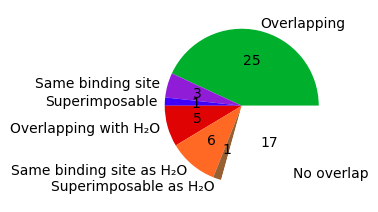

In [23]:
plt.figure(figsize=(2.5,2.5))
_=plt.pie(values22,colors=colors,labels=labels,autopct=autopct_format(values22))
plt.savefig("Supplpie_mg_22.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_mg_22.svg", bbox_inches="tight")

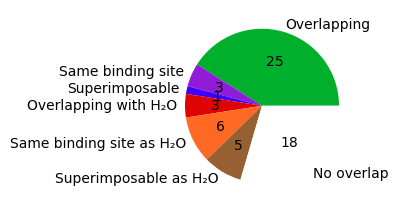

In [24]:
plt.figure(figsize=(2.5,2.5))
_=plt.pie(values23,colors=colors,labels=labels,autopct=autopct_format(values23))
plt.savefig("Supplpie_mg_23.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_mg_23.svg", bbox_inches="tight")

In [25]:
df22wat_non['resolve'] = df22wat_non.Qscore>=SWIM_QSCORE_22
df22wat_non['resolve in both half maps'] = (df22wat_non.Qscore_A>=SWIM_QSCORE_22)&(df22wat_non.Qscore_B>=SWIM_QSCORE_22)
df22wat_non['resolve in one half map'] = (df22wat_non.Qscore_A>=SWIM_QSCORE_22)|(df22wat_non.Qscore_B>=SWIM_QSCORE_22)

print(df22wat_non.resolve.value_counts())
df22wat_non['highdenisty'] = df22wat_non.mapvalue>=SWIM_MAPVALUE
print(df22wat_non.highdenisty.value_counts())
print((df22wat_non.highdenisty & df22wat_non.resolve).sum())
df22mg_non['resolve'] = df22mg_non.Qscore>=SWIM_QSCORE_22
df22mg_non['resolve in both half maps'] = (df22mg_non.Qscore_A>=SWIM_QSCORE_22)&(df22mg_non.Qscore_B>=SWIM_QSCORE_22)
df22mg_non['resolve in one half map'] = (df22mg_non.Qscore_A>=SWIM_QSCORE_22)|(df22mg_non.Qscore_B>=SWIM_QSCORE_22)
print(df22mg_non.resolve.value_counts())
df22mg_non['highdenisty'] = df22mg_non.mapvalue>=SWIM_MAPVALUE
print(df22mg_non.highdenisty.value_counts())
print((df22mg_non.highdenisty & df22mg_non.resolve).sum())

True     63
False    23
Name: resolve, dtype: int64
True     47
False    39
Name: highdenisty, dtype: int64
45
True     12
False     5
Name: resolve, dtype: int64
True     10
False     7
Name: highdenisty, dtype: int64
8


In [26]:
df23wat_non['resolve'] = df23wat_non.Qscore>=SWIM_QSCORE_23
df23wat_non['resolve in both half maps'] = (df23wat_non.Qscore_A>=SWIM_QSCORE_23)&(df23wat_non.Qscore_B>=SWIM_QSCORE_23)
df23wat_non['resolve in one half map'] = (df23wat_non.Qscore_A>=SWIM_QSCORE_23)|(df23wat_non.Qscore_B>=SWIM_QSCORE_23)

df23wat_non['highdenisty'] = df23wat_non.mapvalue>=SWIM_MAPVALUE
print(df23wat_non.resolve.value_counts())
print(df23wat_non.highdenisty.value_counts())
print((df23wat_non.highdenisty & df23wat_non.resolve).sum())
df23mg_non['resolve'] = df23mg_non.Qscore>=SWIM_QSCORE_23
df23mg_non['resolve in both half maps'] = (df23mg_non.Qscore_A>=SWIM_QSCORE_23)&(df23mg_non.Qscore_B>=SWIM_QSCORE_23)
df23mg_non['resolve in one half map'] = (df23mg_non.Qscore_A>=SWIM_QSCORE_23)|(df23mg_non.Qscore_B>=SWIM_QSCORE_23)
print(df23mg_non.resolve.value_counts())
df23mg_non['highdenisty'] = df23mg_non.mapvalue>=SWIM_MAPVALUE
print(df23mg_non.highdenisty.value_counts())
print((df23mg_non.highdenisty & df23mg_non.resolve).sum())

True     87
False    28
Name: resolve, dtype: int64
True     72
False    43
Name: highdenisty, dtype: int64
64
True     13
False     5
Name: resolve, dtype: int64
True     11
False     7
Name: highdenisty, dtype: int64
9


In [27]:
# get closest atom
def check_ion_geom(pdb_f,coords):
    # read pdb and keep only heavy atoms
    pdb = PandasPdb().read_pdb(pdb_f)
    pdb.df["ATOM"] = pdb.df["ATOM"][pdb.df["ATOM"].element_symbol!="H"].reset_index()
    results = []
    for i,ref in enumerate(coords):
        # get closest RNA
        atomdist = pdb.distance(xyz=ref, records=('ATOM',))
        atommin = atomdist.min()
                
        # get closest solvent
        hetdist = pdb.distance(xyz=ref, records=('HETATM',))
        # get rid of compare to itself
        hetdist[hetdist==0] = np.inf
        # get rid of partial occupancy of same type and near
        if float(pdb.df["HETATM"].loc[i,"occupancy"])<1:
            hetdist[(hetdist<3.5) & (pdb.df["HETATM"].occupancy.astype(float)<1) & (pdb.df["HETATM"].residue_name == pdb.df["HETATM"].loc[i,"residue_name"])] = np.inf
        hetmin = hetdist.min()
        
        if atommin < 1.8 or hetmin < 1.8 or min([atommin,hetmin])>2.5:
            results.append(False)
            continue
        
        CPdists = atomdist[pdb.df["ATOM"].element_symbol.isin(["C","P"])]
        if CPdists.min()<3.2:
            results.append(False)
            continue

        aminedists = atomdist[((pdb.df["ATOM"].residue_name=="A")&(pdb.df["ATOM"].atom_name=="N6")) | 
                              ((pdb.df["ATOM"].residue_name=="U")&(pdb.df["ATOM"].atom_name=="N3")) | 
                              ((pdb.df["ATOM"].residue_name=="C")&(pdb.df["ATOM"].atom_name=="N4")) | 
                              ((pdb.df["ATOM"].residue_name=="G")&(pdb.df["ATOM"].atom_name.isin(["N1","N2"])))]
        if aminedists.min() <2.5:
            results.append(False)
            continue
        results.append(True)
    return results

# get closest atom
def check_water_geom(pdb_f,coords):
    # read pdb and keep only heavy atoms
    pdb = PandasPdb().read_pdb(pdb_f)
    pdb.df["ATOM"] = pdb.df["ATOM"][pdb.df["ATOM"].element_symbol!="H"].reset_index()
    results = []
    for i,ref in enumerate(coords):
        # get closest RNA
        atomdist = pdb.distance(xyz=ref, records=('ATOM',))
        atommin = atomdist.min()
                
        # get closest solvent
        hetdist = pdb.distance(xyz=ref, records=('HETATM',))
        # get rid of compare to itself
        hetdist[hetdist==0] = np.inf
        # get rid of partial occupancy of same type and near
        if float(pdb.df["HETATM"].loc[i,"occupancy"])<1:
            hetdist[(hetdist<3.5) & (pdb.df["HETATM"].occupancy.astype(float)<1) & (pdb.df["HETATM"].residue_name == pdb.df["HETATM"].loc[i,"residue_name"])] = np.inf
        hetmin = hetdist.min()
        
        if atommin < 2.5 or hetmin < 2.5 or min([atommin,hetmin])>3.5:
            results.append(False)
            continue
        
        CPdists = atomdist[pdb.df["ATOM"].element_symbol.isin(["C","P"])]
        if CPdists.min()<3.2:
            results.append(False)
            continue
        results.append(True)
    return results

df23wat_non['geom'] = check_water_geom(PDB22_F,df23wat_non[['x_coord','y_coord','z_coord']].to_numpy())
df22wat_non['geom'] = check_water_geom(PDB23_F,df22wat_non[['x_coord','y_coord','z_coord']].to_numpy())
df23mg_non['geom'] = check_ion_geom(PDB22_F,df23mg_non[['x_coord','y_coord','z_coord']].to_numpy())
df22mg_non['geom'] = check_ion_geom(PDB23_F,df22mg_non[['x_coord','y_coord','z_coord']].to_numpy())

#df22mg_non.to_csv('for_greg_22mg_nonagree.csv',index=False)
#df23mg_non.to_csv('for_greg_23mg_nonagree.csv',index=False)
#df22wat_non.to_csv('for_greg_22wat_nonagree.csv',index=False)
#df23wat_non.to_csv('for_greg_23wat_nonagree.csv',index=False)

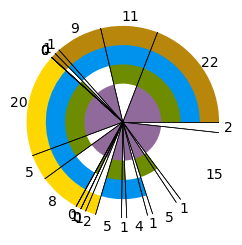

In [29]:
def print_summ(df):
    results = []
    halfboth = (df['resolve in both half maps']) 
    halfone = ((~df['resolve in both half maps']) & (df['resolve in one half map']))
    halfnone = (~df['resolve in one half map'])
    for half in [halfboth, halfone, halfnone]:
        all_good=((half) & (df.highdenisty) & (df.geom) & (df.resolve)).sum()
        not_geom=((half) & df.highdenisty & ~df.geom& df.resolve).sum()
        not_high=((half) & ~df.highdenisty & df.geom& df.resolve).sum()
        res=((half) & (~df.highdenisty) & (~df.geom) & (df.resolve)).sum()
        
        not_res=((half) & (df.highdenisty) & (df.geom) & (~df.resolve)).sum()
        high=((half) & (df.highdenisty) & (~df.geom) & (~df.resolve)).sum()
        geom=((half) & (~df.highdenisty) & (df.geom) & (~df.resolve)).sum()
        none=((half) & (~df.highdenisty) & (~df.geom) & (~df.resolve)).sum()
        
        results.extend([all_good,not_geom,not_high,res,not_res,high,geom,none])
    return results

colors = ['lightgrey','black','purple','red','orange','yellow','green','blue']
labels = ['high density, resolved, ok geometry','not high density nor resolved nor ok geometry',
          'not high density nor resolved',
          'not resolved','not resolved nor ok geometry',
          'not ok geometry','not high densitry nor ok geometry','not high denisty']
fig=plt.figure(figsize=(2.5,2.5))
vals = print_summ(df23wat_non)

colorsdens = ['#6d8c00ff']*2+['white']*2
colorsgeom = ['#8f6a9aff']+['white']
colorsres = ['#0093edff']*4+['white']*4
colorshlaf = ['darkgoldenrod']*8 + ['gold']*8 + ['white']*8

p0=plt.pie(vals,colors=colorshlaf,radius=2,autopct=autopct_format(vals),pctdistance =1.1)
p1=plt.pie(vals,colors=colorsres,radius=1.6)
p2=plt.pie(vals,colors=colorsdens,radius=1.2)
p3=plt.pie(vals,colors=colorsgeom,radius=0.8)
ax=plt.gca()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

for wedge in p0[0]:
    r = wedge.r
    ax.plot([wedge.center[0], r*np.cos(wedge.theta1*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta1*np.pi/180)+wedge.center[1]], linewidth=0.5,color='k')
    ax.plot([wedge.center[0], r*np.cos(wedge.theta2*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta2*np.pi/180)+wedge.center[1]], linewidth=0.5,color='k')

plt.savefig("Supplpie_wat_no_23.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_wat_no_23.svg", bbox_inches="tight")

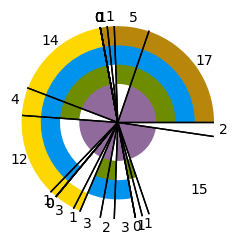

In [30]:
plt.figure(figsize=(2.5,2.5))
vals = print_summ(df22wat_non)

p0=plt.pie(vals,colors=colorshlaf,radius=2,autopct=autopct_format(vals),pctdistance =1.1)
p1=plt.pie(vals,colors=colorsres,radius=1.6)
p2=plt.pie(vals,colors=colorsdens,radius=1.2)
p3=plt.pie(vals,colors=colorsgeom,radius=0.8)
ax=plt.gca()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

for wedge in p0[0]:
    r = wedge.r
    ax.plot([wedge.center[0], r*np.cos(wedge.theta1*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta1*np.pi/180)+wedge.center[1]], linewidth=1,color='k')
    ax.plot([wedge.center[0], r*np.cos(wedge.theta2*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta2*np.pi/180)+wedge.center[1]], linewidth=1,color='k')
plt.savefig("Supplpie_wat_no_22.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_wat_no_22.svg", bbox_inches="tight")

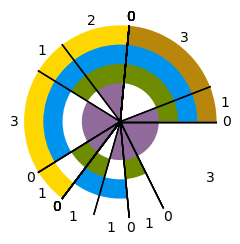

In [31]:
plt.figure(figsize=(2.5,2.5))
vals = print_summ(df22mg_non)
p0=plt.pie(vals,colors=colorshlaf,radius=2,autopct=autopct_format(vals),pctdistance =1.1)
p1=plt.pie(vals,colors=colorsres,radius=1.6)
p2=plt.pie(vals,colors=colorsdens,radius=1.2)
p3=plt.pie(vals,colors=colorsgeom,radius=0.8)

ax=plt.gca()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

for wedge in p0[0]:
    r = wedge.r
    ax.plot([wedge.center[0], r*np.cos(wedge.theta1*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta1*np.pi/180)+wedge.center[1]], linewidth=1,color='k')
    ax.plot([wedge.center[0], r*np.cos(wedge.theta2*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta2*np.pi/180)+wedge.center[1]], linewidth=1,color='k')
plt.savefig("Supplpie_mg_no_22.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_mg_no_22.svg", bbox_inches="tight")

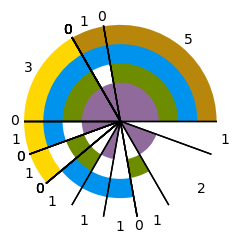

In [32]:
plt.figure(figsize=(2.5,2.5))
vals = print_summ(df23mg_non)
p0=plt.pie(vals,colors=colorshlaf,radius=2,autopct=autopct_format(vals),pctdistance =1.1)
p1=plt.pie(vals,colors=colorsres,radius=1.6)
p2=plt.pie(vals,colors=colorsdens,radius=1.2)
p3=plt.pie(vals,colors=colorsgeom,radius=0.8)
ax=plt.gca()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

for wedge in p0[0]:
    r = wedge.r
    ax.plot([wedge.center[0], r*np.cos(wedge.theta1*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta1*np.pi/180)+wedge.center[1]], linewidth=1,color='k')
    ax.plot([wedge.center[0], r*np.cos(wedge.theta2*np.pi/180)+wedge.center[0]], [wedge.center[1], r*np.sin(wedge.theta2*np.pi/180)+wedge.center[1]], linewidth=1,color='k')
plt.savefig("Supplpie_mg_no_23.png",dpi=dpi, bbox_inches="tight")
plt.savefig("Supplpie_mg_no_23.svg", bbox_inches="tight")

In [33]:
def get_pdb_list(row,atom):
    all_col = row.index.to_list()
    cols = [col for col in all_col if f'consensus of {atom}' in col and 'Å' not in col]
    col_1A = [col for col in all_col if f'within 1A of {atom}' in col and 'Å' not in col]
    col_bs = [col for col in all_col if f'binding spot of {atom}' in col and 'Å' not in col]
    #col_bs = [col for col in all_col if f'exact binding spot of {atom}' in col and 'Å' not in col]
    results = []
    for col,c1A,cbs in zip(cols,col_1A,col_bs):
        pdb = c1A.split()[-1]
        if pdb != col.split()[-1]:
            print("ERROR order")
        add_str = pdb
        if row[col]:
            add_str+='#'
        else:
            if row[c1A]!='0' and row[c1A]!=0:
                add_str+='*'
            if row[cbs]>0:
                add_str+='^'
        if add_str!=pdb:
            results.append(add_str)
    return ', '.join(results)
    
def get_pass_criteria(row):
    criteria = []
    if row.geom:
        criteria.append('Geometry')
    if row.highdenisty:
        criteria.append('Density')
    if row['resolve in both half maps']:
        criteria.append('Resolved in both half maps')
    elif row['resolve in one half map']:
        criteria.append('Resolved in one half map')
    if row.resolve:
        criteria.append('Resolved in full map')
    return ', '.join(criteria)

def get_overlap_symbol(row,atom):
    if row.model == '2.2Å':
        model = '2.3Å'
    else:
        model = '2.2Å'
    col = f'consensus of {atom} in {model}' 
    c1A = f'within 1A of {atom} in {model}' 
    #cbs = f'exact binding spot of {atom} in {model}'
    cbs = f'binding spot of {atom} in {model}'
    add_str = ''
    if row[col]:
        add_str+='#'
    else:
        if row[c1A]!='0' and row[c1A]!=0:
            add_str+='*'
        if row[cbs]>0:
            add_str+='^'
    return add_str

def get_binding_site_name(row):
    ret_str = []
    if row.binding_site==row.binding_site:
        bind_site = row.binding_site.split()
    else:
        bind_site = []
    if row.close_binding_site == row.close_binding_site:
        close_site = row.close_binding_site.split()
    else: close_site = []
    for x in bind_site:
        if x in close_site:
            ret_str.append(x)
        else:
            ret_str.append(x+'†')
    return ', '.join(ret_str)

def get_table_for_paper(df,df2,name):
    table = df.copy()
    table["Overlap with previous structures (Mg)"] = table.apply(lambda row: get_pdb_list(row,'mg'),axis=1)
    table["Overlap with previous structures (water)"] = table.apply(lambda row: get_pdb_list(row,'wat'),axis=1)
    table["Overlap with alterntive model (Mg)"] = table.apply(lambda row: get_overlap_symbol(row,'mg'),axis=1)
    table["Overlap with alterntive model (water)"] = table.apply(lambda row: get_overlap_symbol(row,'wat'),axis=1)
    table['Binding site'] =table.apply(lambda row: get_binding_site_name(row),axis=1)
    df2["Pass criteria"] = df2.apply(lambda row: get_pass_criteria(row),axis=1)
    table = table.merge(df2[["Pass criteria","residue_number"]],on="residue_number",how='outer')
    keep_cols = ['residue_number','Binding site','model',"Overlap with alterntive model (Mg)","Overlap with alterntive model (water)","Overlap with previous structures (Mg)","Overlap with previous structures (water)","Pass criteria"] #
    table = table[keep_cols]
    return table

table22mg = get_table_for_paper(df22mg,df22mg_non,'mg')
table23mg = get_table_for_paper(df23mg,df23mg_non,'mg')
table22wat = get_table_for_paper(df22wat,df22wat_non,'water')
table23wat = get_table_for_paper(df23wat,df23wat_non,'water')


In [34]:
pd.concat([table22mg,table23mg]).sort_values(['model','residue_number']).to_csv('supp_table_mg.csv',index=False)
pd.concat([table22wat,table23wat]).sort_values(['model','residue_number']).to_csv('supp_table_wat.csv',index=False)

In [35]:
print("Deleted for MODEL 1")
print(','.join(df22mg[~(df22mg['overlap mg']=='Overlap')].residue_number.astype(str).to_list()))
print(','.join(df22wat[~(df22wat['overlap water']=='Overlap')].residue_number.astype(str).to_list()))
print("Deleted for MODEL 2")
print(','.join(df22mg[~((df22mg['overlap mg']=='Overlap')|(df22mg['overlap mg'].str.contains('mg')))].residue_number.astype(str).to_list()))
print(','.join(df22wat[~((df22wat['overlap water']=='Overlap')|(df22wat['overlap water'].str.contains('wat')))].residue_number.astype(str).to_list()))

Deleted for MODEL 1
414,417,421,422,423,426,427,428,429,432,434,435,439,440,444,446,447,448,449,451,453,454,456,457,458,459,460,461,462,463,464,465,466
474,482,483,494,504,505,514,517,518,525,532,533,534,535,539,541,543,546,551,555,558,569,571,575,576,578,580,584,585,586,588,595,596,597,598,601,604,605,607,609,610,611,612,613,614,615,623,624,626,628,629,630,631,635,636,637,639,641,642,644,645,646,647,650,651,652,653,654,655,656,658,659,660,665,667,668,670,671,672,673,674,676,677,678,680,683,684,685,686,688,689,692,693,694,695,696,697,698,699,701,702,703,704,705,706,707,709,710,711,712,713,714,715,716,717,718,720,721,722,723,724,725,726,727,729
Deleted for MODEL 2
414,421,422,426,427,428,429,432,434,435,439,444,446,447,448,449,453,454,456,457,458,459,460,461,462,463,464,465,466
482,483,494,504,505,514,518,525,532,533,534,535,539,541,546,551,555,569,571,575,580,584,586,588,595,596,598,601,604,605,607,609,610,611,612,613,623,626,628,629,631,636,637,641,642,645,646,647,650,651,652,653,654,

In [36]:
print("Deleted for MODEL 1")
print(','.join(df23mg[~(df23mg['overlap mg']=='Overlap')].residue_number.astype(str).to_list()))
print(','.join(df23wat[~(df23wat['overlap water']=='Overlap')].residue_number.astype(str).to_list()))
print("Deleted for MODEL 2")
print(','.join(df23mg[~((df23mg['overlap mg']=='Overlap')|(df23mg['overlap mg'].str.contains('mg')))].residue_number.astype(str).to_list()))
print(','.join(df23wat[~((df23wat['overlap water']=='Overlap')|(df23wat['overlap water'].str.contains('wat')))].residue_number.astype(str).to_list()))

Deleted for MODEL 1
414,417,418,419,422,424,425,426,428,430,431,434,438,439,440,441,442,443,447,452,453,454,455,457,458,459,460,461,462,463,464,465,466,467,468,469
470,476,483,491,492,495,496,497,498,502,514,516,519,520,523,525,527,529,538,539,550,551,553,554,557,562,564,566,567,569,571,573,574,576,577,579,580,581,583,585,587,588,589,591,594,596,597,603,606,607,610,612,619,620,623,625,626,629,630,631,632,633,635,637,639,641,642,643,644,646,647,648,650,654,655,656,657,658,659,660,662,664,665,668,669,670,671,672,673,674,675,676,678,679,681,682,688,691,692,693,694,695,696,698,699,700,701,703,704,705,707,708,709,710,711,712,714,715,716,718,719,720,721,722,723,724,725,726,727,728,729,732,734,735,736,737,738,739,742,744,745,748,749,750,751,752,753,754,755,756,757,759,760,761,762,763,764,765,766,767
Deleted for MODEL 2
414,418,419,422,424,426,428,430,431,434,438,439,440,441,442,443,447,452,453,454,455,457,458,460,461,462,463,464,466,467,468,469
470,476,491,492,495,496,497,498,502,516,520,523,